# golive2

...a continuation of the **golive** Jupyter notebook on land ice velocities near Malaspina Glacier.


The pre-masked speed 'vv_masked' is the observation of interest: How does it vary over
the course of several years and across a sizeable region? Some ideas...


- For each location where data exist: accumulate mean speed and std dev to color the scene 
for example using std in relation to a normalized (mean 1) time series; or std/mean.
- Un-supervised clustering such as k-means.


Learning the manipulation tools is part of this process as well. 
To use all available information requires pulling all 255 available NetCDF
files with time intervals ranging from 16 to 96 days. These are concatenated 
into a single time-ordered DataSet, i.e. a three-dimensional data cube in 
contrast to 255 flat arrays. 


An open question: Does pre-screening the source data serve a purpose? It would
*reduce* the data volume while trying to improve data quality by excluding outliers,
particularly artifacts of the velocity estimator. 


Detail: The land/glacier/ocean pixel classification mask *lgo_mask* varies slightly 
from one scene to the next. 


Detail: As noted in the **golive** notebook there are unrealistically high speeds 
in a small portion of the scene.


Detail: Data pre-screening could also check vx, vy consistency. 


In [1]:
%matplotlib inline
import timeit
from datetime import timedelta
from matplotlib import pyplot as plt
import pandas as pd
import netCDF4
import xarray as xr
import numpy as np
from ipywidgets import *                # interactivity
from traitlets import dlink             # interactivity
import sys
import os
from pathlib import Path

# geoscience tools
!pip install utm
!pip install pygeotools
import utm

from osgeo import gdal 
from pygeotools.lib import iolib,timelib

home_d = str(Path.home()) + '/'
data_d = home_d + 'data/'             # A non-repository location for datasets of interest

def dirobj(obj): return [x for x in dir(obj) if not x.startswith('_')]

def lsal(path=''):
    import os
    return os.popen('ls -al ' + path).readlines()

def ShowGitHubImage(username, repo, folder, source, localpath, localname, width, height):
    global home_d
    import requests, shutil
    from PIL import Image
    outf = localpath + '/' + localname
    f = 'https://raw.githubusercontent.com/' + username + '/' + repo + '/master/' + folder + '/' + source
    a = requests.get(f, stream = True)
    if a.status_code == 200:
        with open(outf, 'wb') as f:
            a.raw.decode_content = True
            shutil.copyfileobj(a.raw, f)
    return Image.open(outf).resize((width,height),Image.ANTIALIAS)

def ShowLocalImage(path, filename, width, height):
    from PIL import Image
    f = path + '/' + filename 
    return Image.open(f).resize((width,height),Image.ANTIALIAS)

# Test either of the 'Show Image' functions
# ShowGitHubImage('robfatland', 'othermathclub', 'images/cellular', 'conus_textile_shell_2.png', home_d, 'ctextile.jpg', 450, 250)
# ShowLocalImage(home_d, 'ctextile.jpg', 450, 250)

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# file grabbing code... this takes a few minutes 
golive2_d = data_d + 'golive2/'

if False:
    ftp = FTP('dtn.rc.colorado.edu')
    ftp.login()
    ftp.cwd('work/nsidc0710/nsidc0710_landsat8_golive_ice_velocity_v1.1/p063_r018')
    a=[]
    ftp.dir(a.append)    # This is a rather tricky line of Python as it passes an append method as an argument
    d = [b.split()[8] for b in a if len(b.split()) == 9 and b.split()[8][-3:]=='.nc']
    for i in range(len(d)):
        ftp.retrbinary('RETR ' + d[i], open(golive2_d + d[i], 'wb').write)  
        print('obtained file', i)
    ftp.quit()
    print(len(d))
    # for c in d: print(c)

In [3]:
%%time
# Here are various attempts to dispense with the chars/processing_log stuff; but they are not to the point.
#   Various attempts to drop of squeeze produced affects; but the issue of sorting the source .nc files
#   was related to the need for a sortable dimension which proves to be time.
#
#ds1
#ds1.squeeze('chars', drop=True)
#ds1['vv_masked'].sel(x=':', )
#del ds1['chars']
#ds1 = ds1.sel(x=slice(-1), y=slice(-1))
#ds1
# def pp(ds1):
#     del ds1['processing_log']
#     del ds1['chars']
#     ds1.rename({'chars':'band'},inplace=True)
#     return ds1.assign_coords(band=1)

tslist = []

def pp(ds):
    global tslist
    s = ds['image_pair_times'].attrs['mid_date']
    ts = pd.Timestamp(s)
    while ts in tslist: ts += timedelta(hours = 1)
    tslist.append(ts)
    ds['time'] = xr.Variable('time', [ts])
    return ds

m = xr.open_mfdataset(golive2_d + '*.nc', preprocess = pp, decode_cf=False, autoclose=True, concat_dim='time')

print('there are', len(tslist), 'files in play')

there are 255 files in play
CPU times: user 3min 36s, sys: 20 s, total: 3min 56s
Wall time: 4min 3s


In [4]:
print(m)
print(len(m['time']))
# print(m['image_pair_times'])
m['image_pair_times'].time.values[200]

<xarray.Dataset>
Dimensions:                                         (chars: 4534, time: 255, x: 840, y: 829)
Coordinates:
  * chars                                           (chars) int64 0 1 2 3 4 ...
  * time                                            (time) datetime64[ns] 2013-05-07 ...
  * x                                               (x) float64 3.325e+05 ...
  * y                                               (y) float64 6.537e+06 ...
Data variables:
    image_pair_times                                (time) object b'' b'' ...
    input_image_details                             (time) object b'' b'' ...
    transverse_mercator                             (time) object b'' b'' ...
    offset_correction                               (time) object b'' b'' ...
    applied_bilinear_x_offset_correction_in_pixels  (time, y, x) float32 dask.array<shape=(255, 829, 840), chunksize=(1, 829, 840)>
    applied_bilinear_y_offset_correction_in_pixels  (time, y, x) float32 dask.array<shape=(2

numpy.datetime64('2017-08-22T00:00:00.000000000')

In [5]:
print(type(m['corr']))

<class 'xarray.core.dataarray.DataArray'>


#### Roadmap


Above this point we have created a large xarray DataSet called ```m``` which includes a time axis with 255 entries. 
These span the full time range of what is available for GOLIVE path 63 row 18. 


Next we revisit the four transects of Seward Glacier, a medium-sized glacier feeding the Malaspina piedmont lobe.
The idea is to populate a 255-element time-series graph of ice speed at the center of each of the four transects.


Once that is done -- with timing noted -- we can turn to analyzing the entire dataset. 

In [6]:
# Endpoints determined off of a map representing four lateral transects of Seward glacier
ends = []

ends.append(((60.104166,-140.478055),(60.079166,-140.421944)))
ends.append(((60.150833,-140.494444),(60.14611,-140.400277)))
ends.append(((60.189722,-140.456388),(60.17083,-140.389722)))
ends.append(((60.242222,-140.417500),(60.21805,-140.300277)))

nTransects = len(ends)

utm0, utm1 = [], []
for i in range(nTransects):
    utm0.append(utm.from_latlon(ends[i][0][0],ends[i][0][1]))     # 4-plets
    utm1.append(utm.from_latlon(ends[i][1][0],ends[i][1][1]))

from numpy.linalg import norm
posting = 100.                         # meters

# The following lists have index across the various transects
transects = [(utm1[i][0]-utm0[i][0], utm1[i][1]-utm0[i][1]) for i in range(nTransects)]   # single vector spanning the transect
lengths = [norm(transects[i]) for i in range(nTransects)]                                 # lengths of those vectors
relative_postings = [transects[i]/lengths[i]*posting for i in range(nTransects)]          # a single 'posting vector' (hop)
number_of_postings = [int(lengths[i]/posting) + 1 for i in range(nTransects)]               # number of postings in the transect


print(transects, '\n')
print(lengths, '\n')
print(relative_postings, '\n')
print(number_of_postings, '\n')

[(3144.1744930562563, -2758.1968929581344), (5233.141818051343, -482.24623928405344), (3716.5123229203746, -2071.6535719921812), (6518.903660722659, -2628.9233719613403)] 

[4182.521170670804, 5255.314902376576, 4254.904507596729, 7029.03571149186] 

[array([ 75.17414413, -65.94579634]), array([99.57808267, -9.17635286]), array([ 87.3465507 , -48.68860319]), array([ 92.74250307, -37.40091073])] 

[42, 53, 43, 71] 



In [7]:
# print(m['time'].values) creates a one-element list of dates in string quotes with no delimiters; not useful
print(m['time'])             # a 255-element list (DataArray) of datetime64 values

<xarray.DataArray 'time' (time: 255)>
array(['2013-05-07T00:00:00.000000000', '2013-05-15T00:00:00.000000000',
       '2013-05-23T00:00:00.000000000', ..., '2018-08-25T01:00:00.000000000',
       '2018-09-02T00:00:00.000000000', '2018-09-18T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2013-05-07 2013-05-15 2013-05-23 ...


In [8]:
# This demonstrates in the case of 'x' that time is selected as an array with 255 values...
#   whereas y is speed selected using a particular location; and therefore (as time was not stipulated)
#   is a time-series array of speed values

if False:
    # (xMid, yMid) are UTM coordinates of the mid-point of the four generated transects 
    xMid = utm0[0][0] + (number_of_postings[0]/2.)*relative_postings[0][0]    # These must start at utm0 and add a certain 
    yMid = utm0[0][1] + (number_of_postings[0]/2.)*relative_postings[0][1]    #   number of the relative_postings vectors

    # This was a precursor model of how to produce scatter plots
    x = m['time']
    y = m['vv_masked'].sel(y=yMid,x=xMid,method='nearest').values      

    print(x, y)
        

CPU times: user 49.5 s, sys: 5.63 s, total: 55.1 s
Wall time: 55.3 s


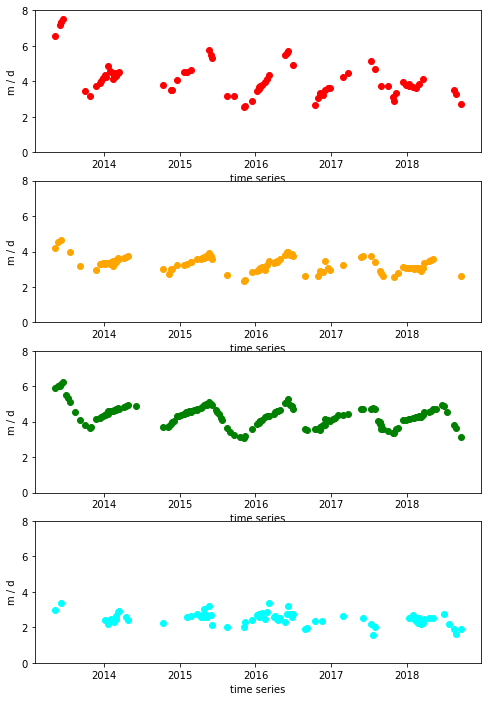

In [9]:
%%time

# Create time-series plots for speeds at the centers of the above four respective lateral transects

# Remember that n16s is how many 16-day-interval results we have; and these are m[0], ..., m[n16s - 1]
maxSpeed = 8.
colorsequence = ['red', 'orange', 'green', 'cyan']
fig,axes = plt.subplots(nTransects)
fig.set_size_inches(8,12)
for i in range(nTransects): axes[i].set(ylim=(0., maxSpeed), xlabel='time series', ylabel = 'm / d')
# plt.subplots_adjust(hspace=0.6)

for t in range(nTransects): 
    xMid = utm0[t][0] + (number_of_postings[t]/2.)*relative_postings[t][0]    # These must start at utm0 and add a certain 
    yMid = utm0[t][1] + (number_of_postings[t]/2.)*relative_postings[t][1]    #   number of the relative_postings vectors
    x = m['time']
    y = m['vv_masked'].sel(y=yMid,x=xMid,method='nearest').values 
    axes[t].plot(x, y, 'o', color=colorsequence[t])
        

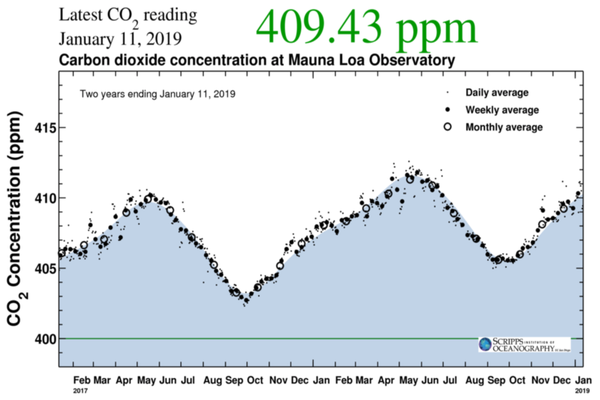

In [10]:
# Say that shape reminds me of something...
ShowLocalImage('./', 'keeling.png', 600, 400)

In [11]:
# This cell establishes that the lgo_mask DataArray changes from one data result to another
if False:
    xice = 702
    yice = 402
    for i in range(10):
        lgoval = lgo.isel(y=yice,x=xice,time=i).values
        vvval = vv.isel(y=yice,x=xice,time=i).values
        corrval = corr.isel(y=yice,x=xice,time=i).values
        northval = north.isel(y=yice).values
        eastval = east.isel(x=xice).values
        print(lgoval, vvval, corrval, northval, eastval)

In [12]:
# Establish that the lgo_mask (land / glacier / ocean) varies from one result to another somewhat
# This makes it intrinsically more difficult to settle on a set of for-sure-this-is-moving-ice pixels
if False:
    lgo=m['lgo_mask']
    fig,axes = plt.subplots(1, 2)
    lgo.isel(time=5).plot(ax=axes[0])
    lgo.isel(time=6).plot(ax=axes[1])
    fig.set_size_inches(18,8)
    axes[0].set(xlim=(480000,570000),ylim=(6630000,6694000))
    axes[1].set(xlim=(480000,570000),ylim=(6630000,6694000))

In [13]:
%%time

# prints time used when the cell is done running

# use the timer to ingest this time into a program...

start_time = timeit.default_timer()

# Here we average time series mask values (0 for ice, 1 for land) across time-series using values.mean()
if False:
    for j in range(401,403):
        for i in range(701,703):
            print(lgo.isel(y=j,x=i).values.mean())

# ...as here the time interval comes programmatically off the timer
print(timeit.default_timer() - start_time)


1.4211982488632202e-06
CPU times: user 180 µs, sys: 0 ns, total: 180 µs
Wall time: 152 µs


In [14]:
# More analysis of the lgo mask using isel to demonstrate 'select by integer index' rather than by dictionary values

if False:
    count = 0
    # for q in m[]
    for j in range(829):
        for i in range(840):
            meanlgo = lgo.isel(y=j,x=i).mean()
            if meanlgo < 0.1:
                print('found ice at', i, j, 'with zeroness', meanlgo)
                count += 1
            if count > 10: break
        if count > 10: break  

### Part 3 Analyze everything

#### 3.1 Analyze one pixel really carefully


What to observe? Let's simplify (at least conceptually) by considering this question for just
one location in the DataSet.


Procedural for 3.1


* Select a UTM coordinate pair from the transects (center of first transect in fact)
* Obtain its integer indices
* Verify that both coordinate and integer indexing produce the same 255-element ndarray
  * We find that the subset of the DataArray is itself a DataArray...
  * ...but the .values extraction is a numpy ndarray, an immutable vector...
  * ...that looks like a list without commas, supports a number of vector methods and so on
* Verify this contains no-data values -9999.
* Use the intrinsic .mean() method to get the mean ignoring the -9999 values
  * compare this by hand with a numpy .mean() method
* use numpy .std() standard deviation to obtain that
  * Again it is worth verifying everything works once
* How many good data values out of 255?
* How many lgo == 0 here? (0 meaning 'glacier' in the mask)
* See that an entire vector of -9999. is handled gracefully

In [15]:
%%time

lgo = m['lgo_mask']
vv = m['vv_masked']

# Use the mid-point of the lower transect, the one closest to Malaspina
xMid = utm0[0][0] + (number_of_postings[0]/2.)*relative_postings[0][0]    # These must start at utm0 and add a certain 
yMid = utm0[0][1] + (number_of_postings[0]/2.)*relative_postings[0][1]    #   number of the relative_postings vectors

print('UTM of point of interest is', xMid, yMid, 'as easting - northing\n')

if False:
    s = vv.sel(x=xMid,y=yMid,method='nearest')        # selects a time series at one location (xMid, yMid)
    ss = s.where(s.values >= 0.)                      # substitutes nan for -9999. no data value

# each of the following does something relevant: 
#   print(s.values)                       prints speeds as an ndarray (not a list; no commas!)
#   print(s)                              describes DataArray (since it was derived from m['vv_masked'])        
#   s.plot()                              uses .plot() native to DataArray to show a plot (-9999 to 30 m/d)
#   print(ss.values)                      shows the nan value substitution in ss
#   print(ss.mean(skipna=True).values)    use DataArray .mean() to ignore nans and print a mean of 4.127929 (sd 1.0109311)
#   print(np.std([1., 2., 3.]))           sidebar numpy operating on a list
#   print(s.x, '\n')
#   print(s, '\n')
#   print(s.masking_info, '\n')
#   print(s['time'])
#   dirobj(s)
#   dirobj(s.x)

UTM of point of interest is 530599.7680965028 6661741.749429959 as easting - northing

CPU times: user 864 µs, sys: 0 ns, total: 864 µs
Wall time: 718 µs


In [16]:
q=vv.sel(x=5.305e+05,y=6.662e+06,time='2013-05-07',method='nearest')
qq=q.to_dataframe()
# print(dirobj(q))
print('\n')
print(qq.index)
print('\n')
dirobj(qq)
# print(q.get_index('time'))
# vv.where(vv==vv.max(), drop=True)
# Here are all the q elements I tried printing in searching for the source integer coordinates
# T, all, all(), argsort, attrs, coords (works nicely for utm and date...), data, dims,  
# values gives [6.517985]
# 'dims', 'dot', 'drop', 
#  'dropna', 'dt', 'dtype', 'encoding', 'equals', 'expand_dims', 'ffill', 'fillna', 'from_cdms2', 'from_dict', 
#  'from_iris', 'from_series', 'get_axis_num', 'get_index', 'grid_mapping', 'groupby', 'groupby_bins', 
#  'identical', 'imag', 'indexes', 'interp', 'interp_like', 'interpolate_na', 'isel', 'isel_points', 'isin', 
#  'isnull', 'item', 'load', 'loc', 'long_name', 'masking_info', 'max', 'mean', 'median', 'min', 'name', 
#  'nbytes', 'ndim', 'notnull', 'persist', 'pipe', 'plot', 'prod', 'quantile', 'rank', 'real', 'reduce', 
#  'reindex', 'reindex_like', 'rename', 'reorder_levels', 'resample', 'reset_coords', 'reset_index', 'roll', 
#  'rolling', 'round', 'searchsorted', 'sel', 'sel_points', 'set_index', 'shape', 'shift', 'size', 'sizes', 
#  'sortby', 'squeeze', 'stack', 'standard_name', 'std', 'sum', 'swap_dims', 'time', 'to_cdms2', 'to_dataframe', 
#  'to_dataset', 'to_dict', 'to_index', 'to_iris', 'to_masked_array', 'to_netcdf', 'to_pandas', 'to_series', 
#  'transpose', 'units', 'unstack', 'values', 'var', 'variable', 'where', 'x', 'y']



DatetimeIndex(['2013-05-07'], dtype='datetime64[ns]', name='time', freq=None)




['T',
 'abs',
 'add',
 'add_prefix',
 'add_suffix',
 'agg',
 'aggregate',
 'align',
 'all',
 'any',
 'append',
 'apply',
 'applymap',
 'as_matrix',
 'asfreq',
 'asof',
 'assign',
 'astype',
 'at',
 'at_time',
 'axes',
 'between_time',
 'bfill',
 'bool',
 'boxplot',
 'clip',
 'clip_lower',
 'clip_upper',
 'columns',
 'combine',
 'combine_first',
 'compound',
 'copy',
 'corr',
 'corrwith',
 'count',
 'cov',
 'cummax',
 'cummin',
 'cumprod',
 'cumsum',
 'describe',
 'diff',
 'div',
 'divide',
 'dot',
 'drop',
 'drop_duplicates',
 'dropna',
 'dtypes',
 'duplicated',
 'empty',
 'eq',
 'equals',
 'eval',
 'ewm',
 'expanding',
 'ffill',
 'fillna',
 'filter',
 'first',
 'first_valid_index',
 'floordiv',
 'from_dict',
 'from_records',
 'ftypes',
 'ge',
 'get',
 'get_dtype_counts',
 'get_ftype_counts',
 'get_values',
 'groupby',
 'gt',
 'head',
 'hist',
 'iat',
 'idxmax',
 'idxmin',
 'iloc',
 'index',
 'infer_objects',
 'info',
 'insert',
 'interpolate',
 'isin',
 'isna',
 'isnull',
 'items',
 '

In [17]:
print(vv.sel(x=5.767e+05,y=6.719e+06,time='2013-05-07',method='nearest').values)

[-9999.]


In [18]:
%%time

s = vv.sel(x=xMid,y=yMid,method='nearest')
ss = s.where(s.values >= 0.).values
sss = ss[~np.isnan(ss)]
print(sss.std())
print(sss.mean())

1.0109311
4.1279287
CPU times: user 24.8 s, sys: 2.43 s, total: 27.2 s
Wall time: 27.3 s


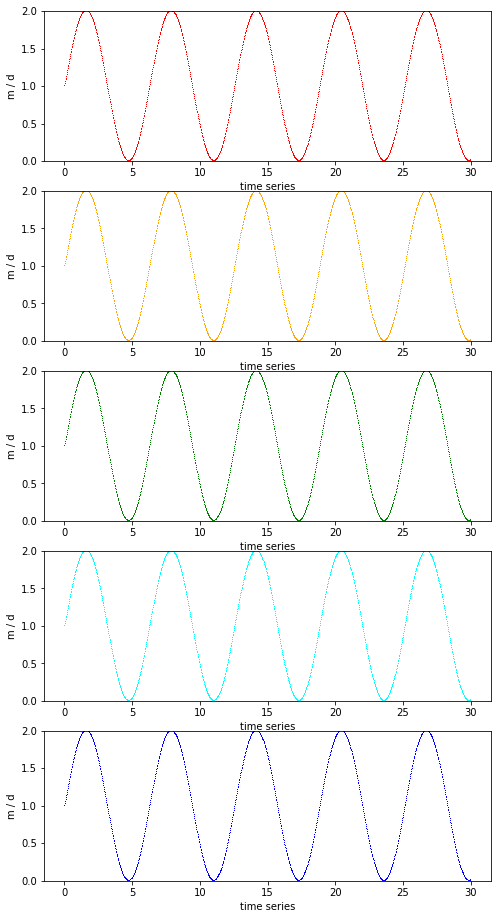

In [19]:
# Aggregate normed speeds everywhere

maxNormedSpeed = 2.
colorsequence = ['red', 'orange', 'green', 'cyan', 'blue']  # blue 0 - 1, cyan 1 - 2, greeen 2 - 3, orange 3 - 4, red 4+
thresholds = [1.0, 2.0, 3.0, 4.0]
nPlots = len(thresholds) + 1
fig,axes = plt.subplots(nPlots)
fig.set_size_inches(8,16)
for i in range(nPlots): axes[i].set(ylim=(0., maxNormedSpeed), xlabel='time series', ylabel = 'm / d')
# plt.subplots_adjust(hspace=0.6)


# xMid = utm0[t][0] + (number_of_postings[t]/2.)*relative_postings[t][0]    # These must start at utm0 and add a certain 
# yMid = utm0[t][1] + (number_of_postings[t]/2.)*relative_postings[t][1]    #   number of the relative_postings vectors
# x = m['time']
# y = m['vv_masked'].sel(y=yMid,x=xMid,method='nearest').values 

x = np.arange(0.0, 30.0, 0.025)
y = np.sin(x) + 1
for i in range(nPlots): axes[i].plot(x, y, ',', color=colorsequence[i])

In [20]:
%%time
# x: 840, y: 829 are the extents of the scene; 255 time values
print('total available pixels:', 840*829)
# s = m['vv_masked'].sel(x=xMid,y=yMid,method='nearest')
s = m['vv_masked'].isel(x=537,y=319)
# print(s)
ss = s.where(s.values >= 0.).values
print(ss)
sss = ss[~np.isnan(ss)]
print(sss.std())
print(sss.mean())
print(sss)
print(len(sss))
print(sss.std()/sss.mean())

total available pixels: 696360
[       nan        nan        nan        nan 0.04521963        nan
        nan        nan 0.03802118        nan        nan        nan
        nan        nan        nan        nan        nan 0.11153932
        nan        nan        nan        nan        nan        nan
 0.05546347        nan 0.01237118        nan 0.05618596        nan
 0.043025          nan        nan 0.04001779        nan        nan
 0.36034146        nan 0.08893257 0.3560301         nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.03709877        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        n

In [21]:
m

<xarray.Dataset>
Dimensions:                                         (chars: 4534, time: 255, x: 840, y: 829)
Coordinates:
  * chars                                           (chars) int64 0 1 2 3 4 ...
  * time                                            (time) datetime64[ns] 2013-05-07 ...
  * x                                               (x) float64 3.325e+05 ...
  * y                                               (y) float64 6.537e+06 ...
Data variables:
    image_pair_times                                (time) object b'' b'' ...
    input_image_details                             (time) object b'' b'' ...
    transverse_mercator                             (time) object b'' b'' ...
    offset_correction                               (time) object b'' b'' ...
    applied_bilinear_x_offset_correction_in_pixels  (time, y, x) float32 dask.array<shape=(255, 829, 840), chunksize=(1, 829, 840)>
    applied_bilinear_y_offset_correction_in_pixels  (time, y, x) float32 dask.array<shape=(2

In [22]:
print(len(sss))
print(sss.sum()/42.)

42
0.0834417116074335


In [23]:
%%time
a = m['vv_masked'].load()

CPU times: user 12.4 s, sys: 1.82 s, total: 14.2 s
Wall time: 14.3 s


In [24]:
a

<xarray.DataArray 'vv_masked' (time: 255, y: 829, x: 840)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2013-05-07 2013-05-15 2013-05-23 ...
  * x        (x) float64 3.325e+05 3.328e+05 3.331e+05 3.334e+05 3.337e+05 ...
  * y        (y) float64 6.537e+06 6.538e+06 6.538e+06 6.538e+06 6.539e+06 ...
Attributes:
    _FillValue:     -9999.0
    grid_m

In [25]:
asom=a.std('time')/a.mean('time')

In [26]:
asom

<xarray.DataArray 'vv_masked' (y: 829, x: 840)>
array([[-0., -0., -0., ..., -0., nan, nan],
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., -0., -0.],
       ...,
       [-0., -0., -0., ..., -0., -0., -0.],
       [-0., -0., -0., ..., -0., nan, nan],
       [nan, -0., -0., ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * x        (x) float64 3.325e+05 3.328e+05 3.331e+05 3.334e+05 3.337e+05 ...
  * y        (y) float64 6.537e+06 6.538e+06 6.538e+06 6.538e+06 6.539e+06 ...

(6630000, 6694000)

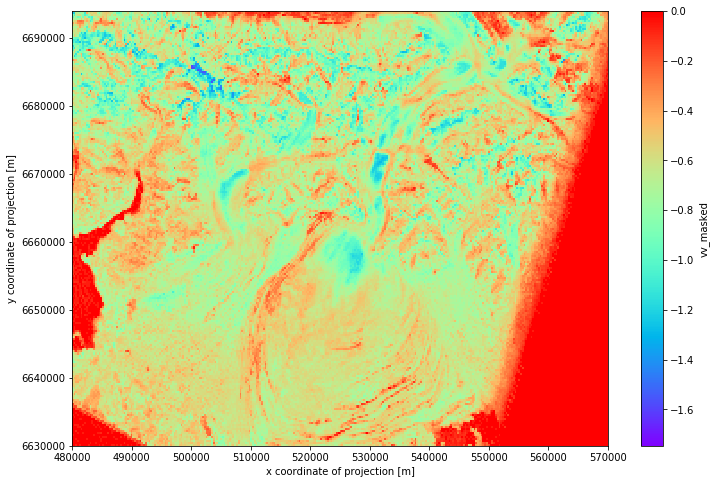

In [27]:
# put these limits on sliders; and a split plot; and no color bar; and color range printed with sliders; no negative
theplot = asom.plot(figsize=(12,8),cmap=plt.cm.rainbow)
plt.xlim(480000,570000)
plt.ylim(6630000,6694000)

In [28]:
print(asom.isel(x=537,y=319))

<xarray.DataArray 'vv_masked' ()>
array(-0.444058, dtype=float32)
Coordinates:
    x        float64 4.936e+05
    y        float64 6.633e+06


In [29]:
test = a.data

In [30]:
test.shape

(255, 829, 840)

In [31]:
type(test[0,0,0])

numpy.float32

In [36]:
a1 = a.isel(x=537,y=319)
a1

<xarray.DataArray 'vv_masked' (time: 255)>
array([-9.999000e+03, -9.999000e+03, -9.999000e+03, ..., -9.999000e+03,
       -9.999000e+03,  4.229403e-02], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2013-05-07 2013-05-15 2013-05-23 ...
    x        float64 4.936e+05
    y        float64 6.633e+06
Attributes:
    _FillValue:     -9999.0
    grid_mapping:   transverse_mercator
    standard_name:  speed_masked
    long_name:      magnitude of velocity (masked)
    units:          m/d
    masking_info:   masked_where(((del_corr_arr<0.100)&(corr_arr<1.000))|(cor...

<class 'xarray.core.dataarray.DataArray'>


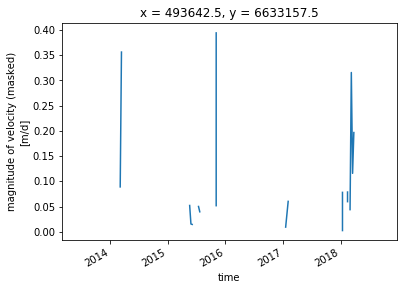

In [40]:
a2 = a1.where(a1.data >= 0.)
print(type(a2))
a2.plot()

In [60]:
sum = 0.
count = 0.
for i in range(255):
    if a2[i].data > 0.:
        sum += a2[i].data
        count += 1
print (sum, count, sum/count, a2.mean().data, a2.std().data, a2.std().data/a2.mean().data)

3.5045518453698605 42.0 0.0834417106040443 0.08344171196222305 0.09796031564474106 1.1739969535751025


In [83]:
m1 = m['lgo_mask'].load()

In [85]:
m2 = m1.where(m1.data >= 0.)
m3 = m2.where(m2.data <= 2.)
m4 = m3.mean('time')
m5 = m4.where(m4.data <= 0.2)

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less_equal
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less_equal


In [66]:
a3=a.where(a.data >= 0.).mean('time')
a4=a.where(a.data >= 0.).std('time')

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app


In [67]:
print(a3.isel(x=537,y=319).data)
print(a4.isel(x=537,y=319).data)

0.08344171
0.097960316


/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater_equal


(6630000, 6730000)

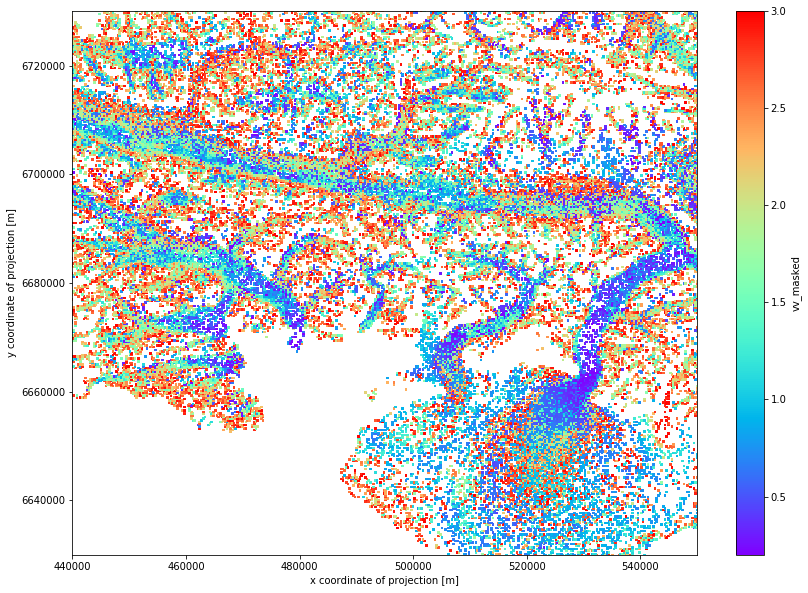

In [86]:
a5=a4/a3
a6 = a5.where(a5.data < 3.0)
a7 = a6.where(a6.data > 0.2)
a8 = a7.where(m5.data >= 0.0)
a8.plot(figsize=(14,10),cmap=plt.cm.rainbow,vmin=0.2, vmax=3.0)
plt.xlim(440000,550000)
plt.ylim(6630000,6730000)
# print(a5.isel(x=537,y=319).data)

In [45]:
bb = a.where(a.values >= 0.).values
bb.plot()

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':


AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [44]:
# print(bb)
cc = bb[~np.isnan(bb)]
print(cc)
print(cc.shape)

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':


[1.196128   1.9556888  2.202884   ... 0.10473334 0.04879034 0.01827188]
(16609313,)


In [27]:
%%time
# x: 840, y: 829 are the extents of the scene; 255 time values
print('total available pixels:', 840*829)
# s = m['vv_masked'].sel(x=xMid,y=yMid,method='nearest')
s = a.isel(x=537,y=319)
ss = s.where(s.values >= 0.).values
sss = ss[~np.isnan(ss)]
print(sss.std())
print(sss.mean())
print(sss)

total available pixels: 696360
0.0979603
0.08344171
[0.04521963 0.03802118 0.11153932 0.05546347 0.01237118 0.05618596
 0.043025   0.04001779 0.36034146 0.08893257 0.3560301  0.03709877
 0.05211671 0.01550134 0.01456883 0.05015367 0.03960558 0.04981892
 0.04174253 0.05172128 0.3939947  0.19912766 0.03179627 0.02634162
 0.0213356  0.00590422 0.02417811 0.07987782 0.00924643 0.06027884
 0.08640642 0.02081297 0.07808822 0.00242693 0.05270684 0.05966555
 0.07877365 0.04387258 0.3155522  0.11579452 0.19660139 0.04229403]
CPU times: user 3.15 ms, sys: 321 µs, total: 3.47 ms
Wall time: 3.22 ms


In [28]:
type(a)

xarray.core.dataarray.DataArray

In [29]:
%%time
# x: 840, y: 829 are the extents of the scene; 255 time values
# s = m['vv_masked'].sel(x=xMid,y=yMid,method='nearest')
s = a.isel(x=537,y=319)
ss = s.where(s.values >= 0.).values
sss = ss[~np.isnan(ss)]
print(sss.std())
print(sss.mean())
print(sss)

0.0979603
0.08344171
[0.04521963 0.03802118 0.11153932 0.05546347 0.01237118 0.05618596
 0.043025   0.04001779 0.36034146 0.08893257 0.3560301  0.03709877
 0.05211671 0.01550134 0.01456883 0.05015367 0.03960558 0.04981892
 0.04174253 0.05172128 0.3939947  0.19912766 0.03179627 0.02634162
 0.0213356  0.00590422 0.02417811 0.07987782 0.00924643 0.06027884
 0.08640642 0.02081297 0.07808822 0.00242693 0.05270684 0.05966555
 0.07877365 0.04387258 0.3155522  0.11579452 0.19660139 0.04229403]
CPU times: user 0 ns, sys: 2.57 ms, total: 2.57 ms
Wall time: 2.48 ms
